# 決定木を実装(1層)

In [12]:
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.datasets.samples_generator import make_blobs
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from scipy.stats import mode

## サンプルデータセット

In [31]:
X, y = make_blobs(n_samples=30, centers=2, n_features=2,random_state=0, cluster_std=1)

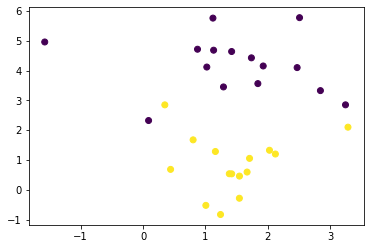

In [32]:
plt.scatter(X[:,0],X[:,1], c=y);

## ジニ不純度を求める関数を作る

$I(t) = 1-\sum_{i=1}^{K}P(C_i|t)^2 = 1-\sum_{i=1}^{K}(\frac{N_{t,i}}{N_{t,all}})^{2}$

In [33]:
def jini(y):
    #count unique label
    classes = np.unique(y)
    sum_prob = 0
    for clas in classes:
        #count number of each label
        cls_sum = np.sum(y == clas)
        sample_num = y.shape[0]
        sum_prob += np.power(cls_sum/sample_num, 2)
    return 1-sum_prob

In [34]:
a = np.array([1,1,1,1,1,1,0])
jini(a)

0.24489795918367352

## ノード間のゲインを計算する関数

$IG(p) = I(p)-\frac{N_{left,all}}{N_{p,all}}I(left)-\frac{N_{right,all}}{N_{p,all}}I(right)$

In [35]:
def jini_gain(p_node, node1, node2):
    p_jini = jini(p_node)
    n1_jini = jini(node1)
    n2_jini = jini(node2)
    n1_sample_rate =  node1.shape[0]/p_node.shape[0]
    n2_sample_rate = node2.shape[0]/p_node.shape[0]
    
    return  p_jini - n1_sample_rate*n1_jini - n2_sample_rate*n2_jini

In [36]:
a = np.array([1,1,1,1,0,0,0,0])
b = np.array([1,1,0,0,0,0])
c = np.array([1,1])
jini_gain(a,b,c)

0.16666666666666669

## 1層決定木のアルゴリズムの実装

In [37]:
threshold = 0
gain = 0
node1 = None
node2 = None
select_col = None
count = 0

# それぞれの列に対して、各サンプル点を閾値として最大のGainを探索
for col in range(X.shape[1]):
    for thr in X[:,col]:
        high_idx = X[:,col] >= thr
        low_idx = X[:,col] < thr
        node_high_y = y[high_idx]
        node_low_y = y[low_idx]
        now_gain = jini_gain(y, node_high_y, node_low_y)
        print("{}: {}".format(count+1,now_gain))
        count+=1
        # 閾値の更新
        if now_gain > gain:
            gain = now_gain
            node1 = node_high_y
            node2 = node_low_y
            threshold = thr
            select_col = col
            print("updated")

1: 0.0357142857142857
updated
2: 0.0
3: 0.006172839506172818
4: 0.0215311004784689
5: 0.0
6: 0.002645502645502673
7: 0.019230769230769218
8: 0.0
9: 0.01000000000000012
10: 0.03600000000000009
updated
11: -1.3877787807814457e-17
12: 0.006172839506172811
13: 0.0031055900621117516
14: 0.004000000000000031
15: 0.017241379310344862
16: 0.0
17: 0.0031055900621117655
18: 0.0
19: 0.040000000000000036
updated
20: 0.011363636363636298
21: 0.02380952380952378
22: 0.013888888888888729
23: 0.0023923444976075847
24: 0.0092592592592593
25: 0.002262443438914019
26: 0.002262443438914019
27: 0.017241379310344862
28: -2.7755575615628914e-17
29: 2.7755575615628914e-17
30: 0.0022222222222222365
31: 0.37555555555555564
updated
32: 0.125
33: 0.15217391304347822
34: 0.18181818181818182
35: 0.33333333333333337
36: 0.09999999999999998
37: 0.017241379310344862
38: 0.0357142857142857
39: 0.25
40: 0.25
41: 0.33333333333333337
42: 0.38235294117647056
updated
43: 0.2894736842105263
44: 0.07692307692307687
45: 0.3823

## 予測

In [38]:
# 前のアルゴリズムで得られた、列と閾値から予測
y_pred = np.where(X[:,select_col] >= threshold,0, 1)

In [39]:
y_pred

array([1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1])

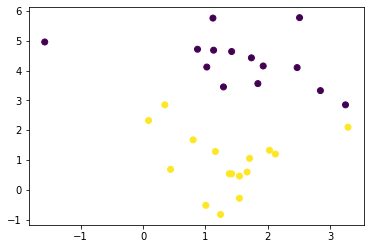

In [40]:
plt.scatter(X[:,0],X[:,1],c=y_pred);

In [41]:
threshold

2.8494216528496255

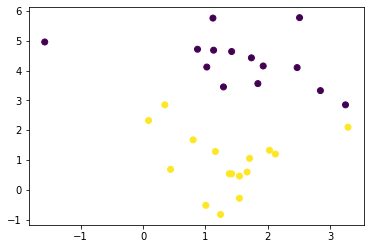

In [42]:
plt.scatter(X[:,0],X[:,1], c=y_pred);

## クラス化

In [49]:
class Tree():
    def __init__(self):
        self.threshold = 0
        self.select_col = None
        self.gain = 0
        self.label = None
        self.node1_label = None
        self.node2_label = None
    def _jini(self, y):
        classes = np.unique(y)
        sum_prob = 0
        sum_mem = 0
        label = 0
        for clas in classes:
            cls_sum = np.sum(y == clas)
            sample_num = y.shape[0]
            sum_prob += np.power(cls_sum/sample_num, 2)
            if sum_mem < cls_sum:
                label = clas
                sum_mem = cls_sum
        return 1-sum_prob, label

    def _jini_gain(self,p_node, node1, node2):
        p_jini, self.label = self._jini(p_node)
        n1_jini, self.node1_label = self._jini(node1)
        n2_jini, self.node2_label = self._jini(node2)
#         print(n2_jini)
        n1_sample_rate =  node1.shape[0]/p_node.shape[0]
        n2_sample_rate = node2.shape[0]/p_node.shape[0]

        return  p_jini - n1_sample_rate*n1_jini - n2_sample_rate*n2_jini
        
    def fit(self,X, y):
        if (X.shape[0]==1):
            print('要素が一つしかありません。')
        else:
            for col in range(X.shape[1]):
                for thr in X[:,col]:
                    high_idx = X[:,col] >= thr
                    low_idx = X[:,col] < thr
                    node_high = y[high_idx]
                    node_low = y[low_idx]
                    now_gain = self._jini_gain(y, node_high, node_low)
                    if now_gain > self.gain:
                        self.gain = now_gain
                        self.threshold = thr
                        self.select_col = col
        
    def predict(self,X):
        # 前のアルゴリズムで得られた、列と閾値から予測

        return np.where(X[:,self.select_col] >= self.threshold, self.node1_label, self.node2_label)

In [50]:
tree =Tree()
tree.fit(X,y)
tree.predict(X)

array([1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1])

In [51]:
tree.predict(X)

array([1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1])

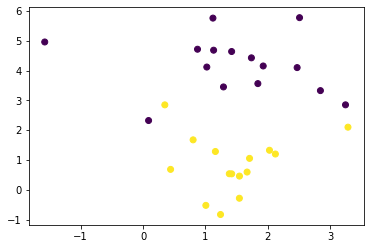

In [52]:
# 正解で色分け
plt.scatter(X[:,0],X[:,1], c=y);

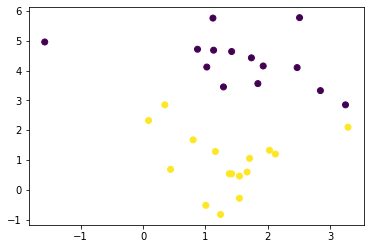

In [59]:
# 予測で色分け
plt.scatter(X[:,0],X[:,1], c=y_pred);